# Analysis of optogenetic activation experiments with short light pulses
## Comparison across experimental groups

About 10 flies are placed in the free walking arena and full-field red light stimulation is delivered repeatedly for short periods.
We are looking for changes in the fly's walking velocities that are associated with the optogenetic activation.

In [18]:
from scipy.io import loadmat
from csv import reader
import numpy as np
from scipy import sparse as sps
from sys import path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import matplotlib.colors as colors

import os
from glob import glob
from os.path import isfile, sep

import seaborn as sns

path.insert(1, '/Users/hannah/Dropbox/code/flyFreeWalking/')
from importCtraxData import importCtraxData

path.insert(1, '/Users/hannah/Dropbox/code/optogeneticsWalkingArena/')
from freeWalkingOptoPlotting import plotSparseMatrix, plotPosInRange, myAxisTheme

%matplotlib inline

# Note: Additional functions are defined at the end of this script. 
# Corresponding cells need to be evaluated before running the ananlysis for the first time

#### Select data directory

In [42]:
basedDir = '/Volumes/jayaramanlab/Hannah/Projects/OptoFreeWalking/1_Data/RewardTest_Laura/fullFieldPulse/'
expDir = 'SS31333-noBal_x_20xCsChrimsonWTB_male_RetWuerzburg/200ms/'
rootDir = basedDir + expDir
expGroup = '_'.join(expDir.split('/')[0:-1])

expList = [filepath.split(sep)[-1] for filepath in glob(rootDir + sep + '*.ufmf')]
sorted(expList)

['SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_male_12h_rep1_2017_06_08_10_37_57_v001.ufmf']

#### Set protocol parameters and generate file name templates

In [43]:
fileNameParts = expGroup.split('_')

genotype = '_'.join(fileNameParts[0:3])
protocolName = '_'.join(fileNameParts[4:6])

stimTms = 200
pauseTms = 15 *1000
fps = 20.0 # Video sampling rate

print(genotype)
print(protocolName)

SS31333-noBal_x_20xCsChrimsonWTB
RetWuerzburg_200ms


In [65]:
starvation = [movie.split('_')[7] for movie in expList]
starveGroup = list(set(starvation))
starveGroup

['12h']

### Setup up directories for plots generated during the analysis

In [45]:
analysisDir = sep.join([rootDir, 'analysis'])

try:
    os.mkdir(analysisDir)
except OSError:
    print('Analysis folder already exists')

In [46]:
for st in starveGroup:
    plotSaveDir = sep.join([analysisDir, st])

    try:
        os.mkdir(plotSaveDir)
    except OSError:
        print('Starvation folder already exists')

## Iterate through data manually
### 1) Select a starvation group (starveG)
### 2) Select a file from the list in this group (fileID)
### 3) Run analysis blocks for the selected file and repeat...

### Select starvation group

In [67]:
starveG = starveGroup[0]
print(starveG)

# Select correct plotting directory:
plotSaveDir = sep.join([analysisDir, starveG])

12h


#### Read pulse start frames from file

In [48]:
expListFile = rootDir + 'firstFrames.csv'
stimPulseFile = rootDir + 'stimFrames.csv'

# load file specifying data to be analysed
fileList = open(expListFile, 'r')
csv_fileList = reader(fileList)

# get header
header = fileList.readline().split(',')

fileNames = []
startFrames = []
stimFrames = []

for i, line in enumerate(csv_fileList):
    if('_'+starveG in line[1]):
        fileNames.append(line[1])
        startFrames.append(line[2])
        
        csv_pulse = reader(open(stimPulseFile))
        for k, line in enumerate(csv_pulse):
            if k == i:
                stimFrames.append(line)
                continue

In [49]:
fileNames

['SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_male_12h_rep1_2017_06_08_10_37_57_v001']

### Select file from list
#### Import and rearrange data

In [50]:
fileInd = 0

In [51]:
fileName = fileNames[fileInd]+'.mat'
startFrame = int(startFrames[fileInd])
stimFrame = stimFrames[fileInd]
expID = fileName.split('_')[8]
print(fileName)
#print(startFrame)
print(expID)

SS31333-noBal_x_20xCsChrimsonWTB_10LED_0-2s_RetWuerzburg_male_12h_rep1_2017_06_08_10_37_57_v001.mat
rep1


In [52]:
stimFrame = [int(stim) for stim in stimFrame]
#stimFrame

#### Extract relevant tracking parameter

In [53]:
## TODO: Replace by importCtraxData function.... 

In [54]:
keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle'] #data columns to be extracted from ctrax file

#load matlab data and convert
indat = loadmat(rootDir + sep + fileName)

dat = [indat[k] for k in keyList]
    
# Reorganise fly position arrays into lists (sorted by frame)
numFrames = len(dat[0])
xPos = []
yPos = []
angle = []
flyID = []

pointer = 0
for t in range(numFrames):
    numFlies = dat[3][t].astype('int')[0]

    xPos.append(dat[1][pointer:pointer+numFlies])
    yPos.append(dat[2][pointer:pointer+numFlies])
    angle.append(dat[5][pointer:pointer+numFlies])
    flyID.append(dat[4][pointer:pointer+numFlies])

    pointer += numFlies
    
xPos = np.array(xPos)
yPos = np.array(yPos)
angle = np.array(angle)
flyID = np.array(flyID)
maxFlyID = max(dat[4])

In [55]:
print("trial length in minutes")
numFrames/(fps*60)

trial length in minutes


4.005

#### Visualise tracking performance

/Users/hannah/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


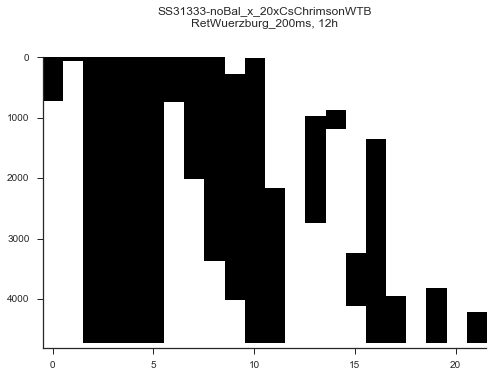

In [56]:
# Reorganise fly track fragments into matrix (frame x fly id )
flyIDperFrame = np.zeros((numFrames,maxFlyID+1))
for frame in range(numFrames):
    for idx in np.array(flyID[frame]).squeeze().astype('int'):
        flyIDperFrame[frame][idx] = 1

#visualise resluting matrix
fragmentFig = plotSparseMatrix((7,5),0.003,flyIDperFrame, genotype + '\n' + protocolName + ', '+ starveG + '\n')
fragmentFig.tight_layout()

fragmentFig.savefig(plotSaveDir+sep+'_'.join([genotype,protocolName,starveG,expID,'traceFragments']) + '.pdf', format = 'pdf')

### Plot tracking data
#### Visualise response of all flies to first light pulse

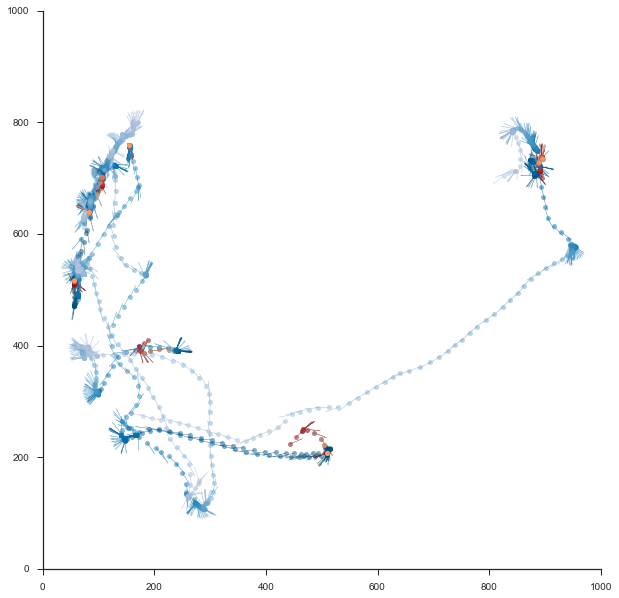

In [57]:
alphaVal = 0.5
arrowScale = 25

fig = plt.figure(figsize=(10,10))
sbplt = fig.add_subplot(111)

firstPause = range(int(startFrame + (stimTms/1000.0)*fps), int(startFrame + (stimTms+pauseTms)/1000.0 * fps),2)
plotPosInRange(sbplt,firstPause,xPos,yPos,angle,flyID,'PuBu', alphaVal, arrowScale)

#plot stimulation on top
firstStim = range(int(startFrame),int(startFrame + np.ceil(stimTms/1000.0) * fps),2)
plotPosInRange(sbplt,firstStim,xPos,yPos,angle,flyID,'OrRd',alphaVal, arrowScale)

fig.savefig(plotSaveDir+sep+'_'.join([genotype,protocolName,starveG,expID,'firstTrialTraces']) + '.pdf', format = 'pdf')

### Plot per-fly walking statistics

In [58]:
numRepeat = len(stimFrame)
vTHigh = 30 # max. plausible translational velocity

#compute translational and rotational velocity over entire experiment
frameRange = range(0,int(stimFrame[-1] + (pauseTms/1000-10) * fps ))

totaltime = [frame/fps for frame in frameRange]

activeFragments = np.array(np.nonzero(sum(flyIDperFrame[frameRange]))).squeeze()

transV = np.nan*np.ones((len(frameRange),len(activeFragments)))
transV_filt = np.nan*np.ones((len(frameRange),len(activeFragments)))
rotV = np.nan*np.ones((len(frameRange),len(activeFragments)))
rotV_filt = np.nan*np.ones((len(frameRange),len(activeFragments)))

for k, fly in enumerate(activeFragments):
    
    currTransV = np.nan*np.ones((len(frameRange),1))
    currRotV = np.nan*np.ones((len(frameRange),1))
    
    for ind,frame in enumerate(frameRange):
        if not np.any(flyID[frame] == float(fly)) or not np.any(flyID[frame-1] == float(fly)):
            #print("No data on fly")
            continue;
            
        currTransV[ind] = np.hypot(xPos[frame][flyID[frame] == fly] - xPos[frame-1][flyID[frame-1] == fly],
                                   yPos[frame][flyID[frame] == fly] - yPos[frame-1][flyID[frame-1] == fly])
        
        currRotV[ind] = angle[frame][flyID[frame] == fly] - angle[frame-1][flyID[frame-1] == fly]
        if(currRotV[ind]>np.pi): currRotV[ind] = currRotV[ind]-2*np.pi
        if(currRotV[ind]<-np.pi): currRotV[ind] = currRotV[ind]+2*np.pi
        
        if currTransV[ind] > vTHigh: currTransV[ind] = np.nan
    
    transV[:,k] = currTransV.squeeze()
    transV_filt[:,k] = np.convolve(currTransV.squeeze(), np.ones((5,))/5, mode='same')
    rotV[:,k] = currRotV.squeeze()
    rotV_filt[:,k] = np.convolve(currRotV.squeeze(), np.ones((5,))/5, mode='same')
    

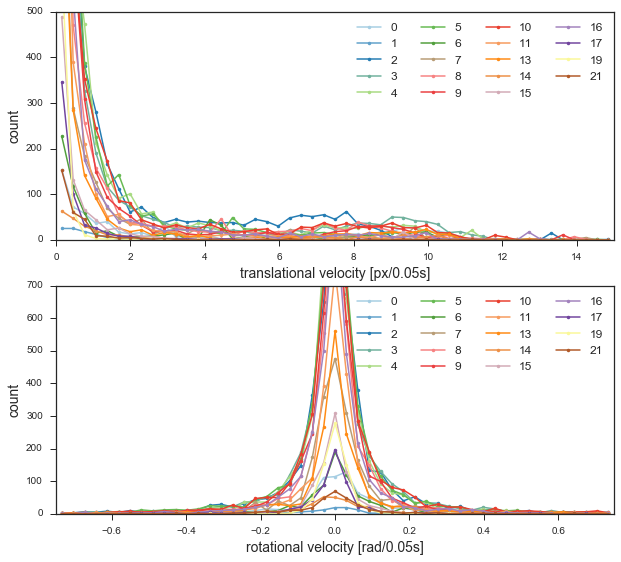

In [59]:
# Plot results
Vfig = plt.figure(figsize=(10,9))
tVplt = Vfig.add_subplot(211)
rVplt = Vfig.add_subplot(212)

vRotRange = 0.75
maxVTrans = 15
numBins = 50

cNorm  = colors.Normalize(vmin=min(activeFragments), vmax=max(activeFragments))
FlyMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Paired')

for k, fly in enumerate(activeFragments):
    flyColor = FlyMap.to_rgba(fly)
        
    histVal, binEdges = np.histogram(transV[:,k],bins=np.linspace(0,maxVTrans,numBins))
    binLoc = binEdges[0:-1]+0.5*np.mean(np.diff(binEdges))
    tVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)
    
    histVal, binEdges = np.histogram(rotV[:,k],bins=np.linspace(-vRotRange,vRotRange,numBins))
    binLoc = binEdges[0:-1]+0.5*np.mean(np.diff(binEdges))
    rVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)


tVplt.set_ylim((0,500))
tVplt.set_xlim((0,maxVTrans))
tVplt.set_xlabel('translational velocity [px/0.05s]',fontsize = 14)
tVplt.set_ylabel('count',fontsize = 14)
tVplt.legend(activeFragments,ncol=4,fontsize = 12)
tVplt.yaxis.set_ticks_position('left')
tVplt.xaxis.set_ticks_position('bottom')

rVplt.set_ylim((0,700))
rVplt.set_xlim((-vRotRange,vRotRange))
rVplt.set_xlabel('rotational velocity [rad/0.05s]',fontsize = 14)
rVplt.set_ylabel('count',fontsize = 14)
rVplt.legend(activeFragments,ncol=4,fontsize = 12)
rVplt.yaxis.set_ticks_position('left')
rVplt.xaxis.set_ticks_position('bottom')

Vfig.savefig(plotSaveDir +sep+'_'.join([genotype,protocolName,starveG,expID,'veloDistribution'])+'.pdf', format='pdf')

#### Trigger on light ON

In [60]:
transV_mean = np.nanmean(transV, axis=1)
rotV_mean = np.nanmean(abs(rotV), axis=1)
transV_median = np.nanmedian(transV, axis=1)
rotV_median = np.nanmedian(abs(rotV), axis=1)

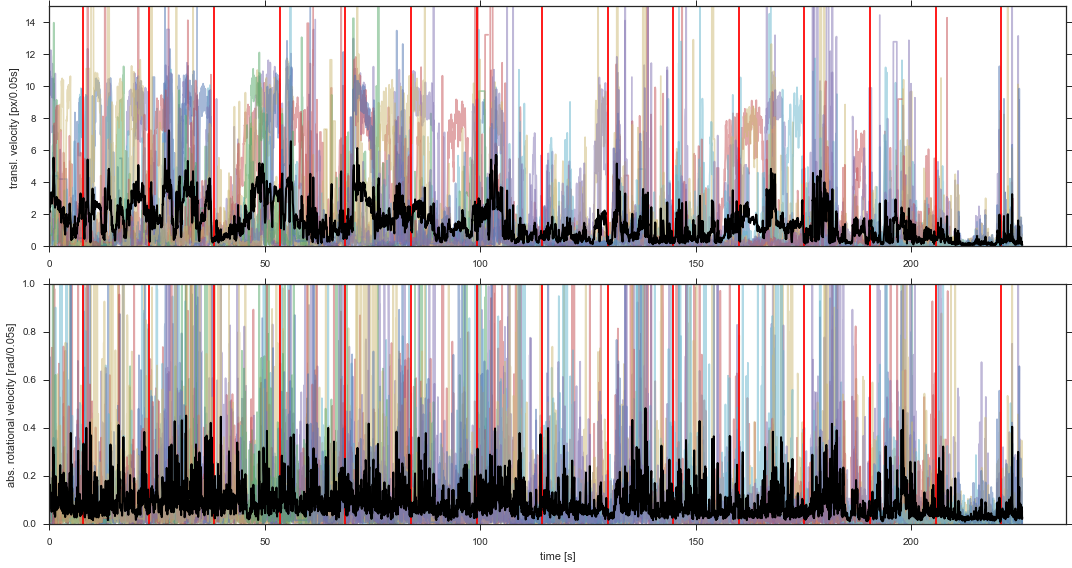

In [61]:
vTRfig = plt.figure(figsize=(15,8))

vTplt = vTRfig.add_subplot(211)
vTplt.plot(totaltime, transV[:,:],alpha=0.5)
for tb in stimFrame:
    vTplt.axvline((tb+1)/fps,color='red')
vTplt.plot(totaltime, transV_mean,color='black', linewidth=2)

vTplt.set_xlim(0,stimFrame[-1]/fps+(pauseTms/1000))
vTplt.set_ylim(0,15)
vTplt.set_ylabel("transl. velocity [px/0.05s]")

vRplt = vTRfig.add_subplot(212)
vRplt.plot(totaltime,abs(rotV[:,:]),alpha=0.5)
for tb in stimFrame:
    vRplt.axvline((tb+1)/fps,color='red')
vRplt.plot(totaltime,rotV_mean,color='black', linewidth=2)
vRplt.set_xlim(0,stimFrame[-1]/fps+(pauseTms/1000))
vRplt.set_ylim(0,1)
vRplt.set_ylabel("abs. rotational velocity [rad/0.05s]")
vRplt.set_xlabel("time [s]")

plt.tight_layout()
vTRfig.savefig(plotSaveDir +sep+'_'.join([genotype,protocolName,starveG,expID,'veloTseries'])+'.pdf', format = 'pdf')

In [62]:
transV_filt_mean = np.nanmean(transV_filt, axis=1)
rotV_filt_mean = np.nanmean(abs(rotV_filt), axis=1)
transV_filt_median = np.nanmedian(transV_filt, axis=1)
rotV_filt_median = np.nanmedian(abs(rotV_filt), axis=1)

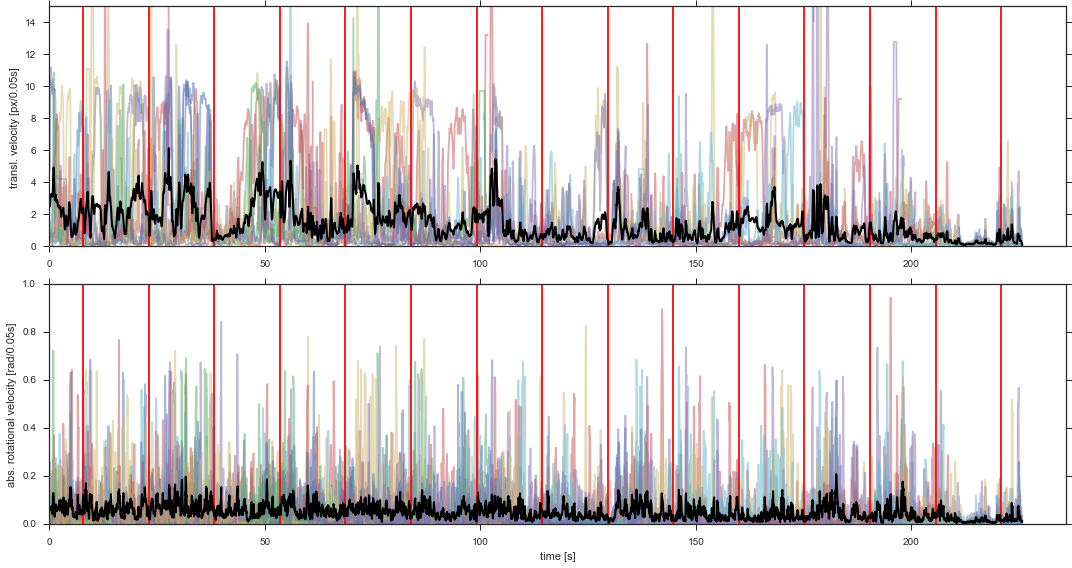

In [63]:
vTRfig = plt.figure(figsize=(15,8))

vTplt = vTRfig.add_subplot(211)
vTplt.plot(totaltime,transV_filt[:,:],alpha=0.5)
for tb in stimFrame:
    vTplt.axvline((tb+1)/fps,color='red')
vTplt.plot(totaltime,transV_filt_mean,color='black', linewidth=2)
vTplt.set_xlim(0,stimFrame[-1]/fps+(pauseTms/1000))
vTplt.set_ylim(0,15)
vTplt.set_ylabel("transl. velocity [px/0.05s]")

vRplt = vTRfig.add_subplot(212)
vRplt.plot(totaltime,abs(rotV_filt[:,:]),alpha=0.5)
for tb in stimFrame:
    vRplt.axvline((tb+1)/fps,color='red')
vRplt.plot(totaltime,rotV_filt_mean,color='black', linewidth=2)
vRplt.set_xlim(0,stimFrame[-1]/fps+(pauseTms/1000))
vRplt.set_ylim(0,1)
vRplt.set_ylabel("abs. rotational velocity [rad/0.05s]")
vRplt.set_xlabel("time [s]")

plt.tight_layout()
vTRfig.savefig(plotSaveDir +sep+'_'.join([genotype,protocolName,starveG,expID,'veloTseries_filt'])+'.pdf', format = 'pdf')

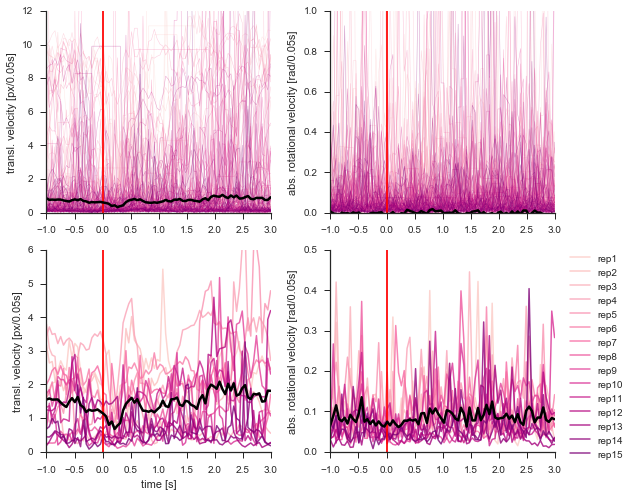

In [69]:
pre = -1
post = 3
timeAx = np.linspace(pre, post, (post-pre)*fps)

if starveG == '0h':
    colMap = 'PuBu'
else:
    colMap = 'RdPu'

vTRfig = plt.figure(figsize=(8,7))

vTplt = vTRfig.add_subplot(221)
vRplt = vTRfig.add_subplot(222)

vTAplt = vTRfig.add_subplot(223)
vRAplt = vTRfig.add_subplot(224)

vTBlock = np.zeros(len(timeAx))
vTBlock_count = 0
vRBlock = np.zeros(len(timeAx))
vRBlock_count = 0

cNorm  = colors.Normalize(vmin=-5, vmax=numRepeat+2)
timeCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=colMap)

legendhs = []
vTABlock = []
vRABlock = []

for ind, tb in enumerate(stimFrame):
    tb = tb+1
    vTplt.plot(timeAx,transV[tb + int(pre*fps) : tb + int(post*fps),:],alpha=0.4, color=timeCMap.to_rgba(ind), linewidth=0.5)
    vTBlock = vTBlock + np.nansum(transV[tb + int(pre*fps) : tb + int(post*fps),:], axis = 1)
    vTBlock_count = vTBlock_count + len(np.sum(transV[tb + int(pre*fps) : tb + int(post*fps),:], axis = 0))
    
    vRplt.plot(timeAx,abs(rotV[tb + int(pre*fps) : tb + int(post*fps),:]),alpha=0.4, color=timeCMap.to_rgba(ind), linewidth=0.5)
    vRBlock = vRBlock + np.nansum(rotV[tb + int(pre*fps) : tb + int(post*fps),:], axis = 1)
    vRBlock_count = vRBlock_count + len(np.sum(rotV[tb + int(pre*fps) : tb + int(post*fps),:], axis = 0))
    
    tb = tb+1
    h, = vTAplt.plot(timeAx,transV_mean[tb + int(pre*fps) : tb + int(post*fps)],alpha=0.8,color=timeCMap.to_rgba(ind), linewidth=1.5)
    vTABlock.append(transV_mean[tb + int(pre*fps) : tb + int(post*fps)])
    
    vRAplt.plot(timeAx,rotV_mean[tb + int(pre*fps) : tb + int(post*fps)],alpha=0.8,color=timeCMap.to_rgba(ind), linewidth=1.5)
    vRABlock.append(rotV_mean[tb + int(pre*fps) : tb + int(post*fps)])
    legendhs.append(h)
    
vTplt.axvline(0,color='red')
vTplt.plot(timeAx,vTBlock/float(vTBlock_count),color='black', linewidth=2.5)
vTplt.set_ylabel("transl. velocity [px/0.05s]")
vTplt.set_ylim(0,12)
myAxisTheme(vTplt)

vRplt.axvline(0,color='red')
vRplt.plot(timeAx,vRBlock/float(vRBlock_count),color='black', linewidth=2.5)
vRplt.set_ylabel("abs. rotational velocity [rad/0.05s]")
vRplt.set_ylim(0,1)
myAxisTheme(vRplt)
    
vTAplt.axvline(0,color='red')
vTAplt.plot(timeAx,np.nanmean(vTABlock, axis=0), color='black', linewidth=2.5)
vTAplt.set_ylim(0,6)
vTAplt.set_ylabel("transl. velocity [px/0.05s]")
vTAplt.set_xlabel("time [s]")
myAxisTheme(vTAplt)

vRAplt.axvline(0,color='red')
vRAplt.plot(timeAx,np.nanmean(vRABlock, axis=0),color='black', linewidth=2.5)
vRAplt.set_ylim(0,0.5)
vRAplt.legend(legendhs, ['rep' + str(i+1) for i in range(numRepeat)],
             bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
vRAplt.set_ylabel("abs. rotational velocity [rad/0.05s]")
myAxisTheme(vRAplt)

# Save per repeat averages as .csv
np.savetxt(analysisDir + '/'  + genotype +'_'+ protocolName + '_'+ starveG + '_' + expID 
           + '_vTrans_triggeredAverage.csv', vTABlock, delimiter=',')
np.savetxt(analysisDir + '/'  + genotype +'_'+ protocolName + '_'+ starveG + '_' + expID 
           + '_vRot_triggeredAverage.csv', vRABlock, delimiter=',')

# Save plot
vTRfig.tight_layout()
vTRfig.savefig(plotSaveDir +sep+ '_'.join([genotype,protocolName,starveG,expID,'triggeredAverages'])+'.pdf', format = 'pdf')